# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [1]:
from sympy import *
init_printing()

In [2]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

[x  y  z  vₓ  v_y  v_z  m]

In [3]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)
T, isp, mu, g = symbols('T I_{sp} \\mu g_0', real=True, positive=True)
c1 = T
c2 = T/(isp*g)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
simplify(ds)

⎡               vₓ                ⎤
⎢                                 ⎥
⎢               v_y               ⎥
⎢                                 ⎥
⎢               v_z               ⎥
⎢                                 ⎥
⎢T⋅\hat{u}ₓ⋅u         \mu⋅x       ⎥
⎢──────────── - ───────────────── ⎥
⎢     m                       3/2 ⎥
⎢               ⎛ 2    2    2⎞    ⎥
⎢               ⎝x  + y  + z ⎠    ⎥
⎢                                 ⎥
⎢T⋅\hat{u}_y⋅u         \mu⋅y      ⎥
⎢───────────── - ─────────────────⎥
⎢      m                       3/2⎥
⎢                ⎛ 2    2    2⎞   ⎥
⎢                ⎝x  + y  + z ⎠   ⎥
⎢                                 ⎥
⎢T⋅\hat{u}_z⋅u         \mu⋅z      ⎥
⎢───────────── - ─────────────────⎥
⎢      m                       3/2⎥
⎢                ⎛ 2    2    2⎞   ⎥
⎢                ⎝x  + y  + z ⎠   ⎥
⎢                                 ⎥
⎢              -T⋅u               ⎥
⎢            ─────────            ⎥
⎣            I_{sp}⋅g₀            ⎦

In [4]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L.simplify()

In [5]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

[\lambda_{x}  \lambda_{y}  \lambda_{z}  \lambda_{v_x}  \lambda_{v_y}  \lambda_
{v_z}  \lambda_{m}]

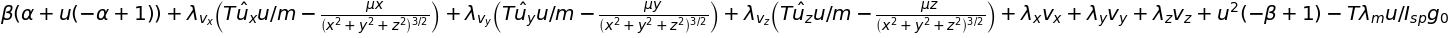

In [6]:
# Hamiltonian
H = l.dot(ds) + L
H

In [7]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
simplify(uhs)

⎡                   -\lambda_{v_x}                    ⎤
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_y}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_z}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎣╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎦

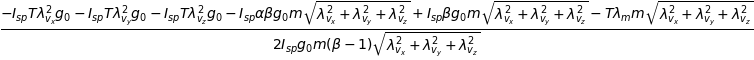

In [8]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums.subs(l[3:6,:].norm(), '\\lambda_v')

In [9]:
us = Matrix([[ums], uhs])
us

⎡                                                                             
⎢                        2                            2                       
⎢- I_{sp}⋅T⋅\lambda_{v_x} ⋅g₀ - I_{sp}⋅T⋅\lambda_{v_y} ⋅g₀ - I_{sp}⋅T⋅\lambda_
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [10]:
# costate equations of motion
dl = -H.diff(s)
dl

⎡                ⎛            2                        ⎞                      
⎢                ⎜     3⋅\mu⋅x               \mu       ⎟   3⋅\lambda_{v_y}⋅\mu
⎢- \lambda_{v_x}⋅⎜───────────────── - ─────────────────⎟ - ───────────────────
⎢                ⎜              5/2                 3/2⎟                    5/
⎢                ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞   ⎟      ⎛ 2    2    2⎞  
⎢                ⎝⎝x  + y  + z ⎠      ⎝x  + y  + z ⎠   ⎠      ⎝x  + y  + z ⎠  
⎢                                                                             
⎢                                          ⎛            2                     
⎢  3⋅\lambda_{v_x}⋅\mu⋅x⋅y                 ⎜     3⋅\mu⋅y               \mu    
⎢- ─────────────────────── - \lambda_{v_y}⋅⎜───────────────── - ──────────────
⎢                   5/2                    ⎜              5/2                 
⎢     ⎛ 2    2    2⎞                       ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞
⎢     ⎝x  + y  + z ⎠                       ⎝⎝x  + y 

In [11]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

⎡                                                                            ⎛
⎢                                                                            ⎜
⎢                                                                           -⎝
⎢                                                                           ──
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                            ⎛                                
⎢                                            ⎜                        2       
⎢                                        zoo⋅⎝- I_{sp}⋅T⋅\lambda_{v_x} ⋅g₀ - I
⎢                                        ─────────────────────────────────────
⎢                                                   

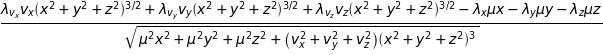

In [12]:
tangent = Matrix([
    (-mu/(p.norm()**3))*p,
    v
])
tangent = tangent/tangent.norm()
l[:-1, :].dot(tangent).simplify()

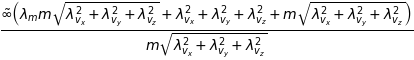

In [13]:
ums.subs(alpha, 0).subs(beta, 1).simplify()

## Base trajectory

In [14]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [15]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [16]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# homotopy parameters
alpha = 0
seg.beta = 0

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# decision vector guess
zg = [379.20912013,   0.93398202,  12.76567896, -45.55493263,  -8.26940351, 49.99989562, 3.00127225, -8.58992837, 8.32972382]

In [17]:
# solve single trajectory
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)

# solve multiple candidate trajectories in parallel
#zl, fl, feasl = seg.solve_par(s0, alpha, 200, 450, 50, npar=1000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


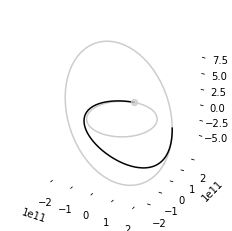

In [18]:
# plot trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
ax = seg.plot_traj(sl, alpha=1)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 0$

In [19]:
# homotopy
alpha = 0
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta0 = np.load('spacecraft_z_beta_homotopy_alpha_0.npy'); alpha = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


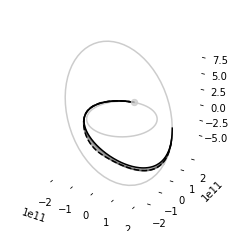

In [20]:
# plot homotopy
for i, t in enumerate(Ta0):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta0) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 1$

In [21]:
# homotopy
alpha = 1
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta1 = np.load('spacecraft_z_beta_homotopy_alpha_1.npy'); alpha = 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


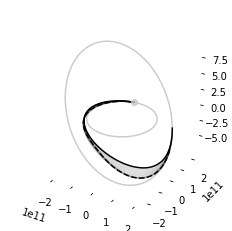

In [22]:
# plot homotopy
for i, t in enumerate(Ta1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\alpha \times [0, 1] : \beta = 1$

In [23]:
# homotopy
alpha = 0
alphag = 1
seg.beta = 0.99999
z = Ta0[-1][0]
#Tb1 = seg.homotopy(s0, alpha, Tlb, Tub, lb, z, alphag, step=0.1, verbose=False)
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


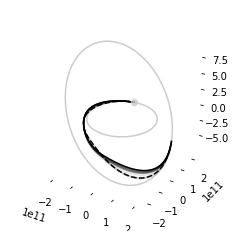

In [24]:
# plot homotopy
for i, t in enumerate(Tb1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    alpha = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Tb1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

## Comparing policy homotopies

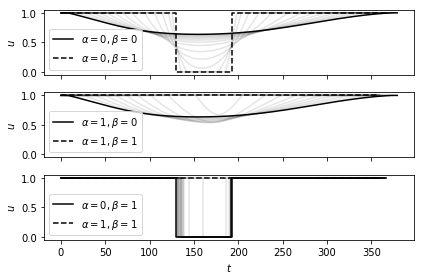

In [25]:
# figure
fig, ax = plt.subplots(3, sharex=True)

alpha = 0
for i, sol in enumerate(Ta0):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta0) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta0) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    
alpha = 1
for i, sol in enumerate(Ta1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta1) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta1) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
        
seg.beta = 0.999999999
for i, sol in enumerate(Tb1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    alpha = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[2].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    elif i == len(Tb1) - 1:
        ax[2].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[2].plot(tl, ul[:,0], "k-", alpha=0.1)
    

ax[2].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$u$')
ax[2].set_ylabel(r'$u$')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='lower left')
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)
ax[2].set_ylim(-0.05, 1.05)

fig.tight_layout()
#fig.savefig('spacecraft_u_full_homotopy.pdf', bbox_inches='tight')
plt.show()

## Random walks at $\beta = 0$

In [26]:
# decision vector and homotopy parameter
z, seg.beta = Ta0[0]
alpha = 0

# number of serial perturbations per walk
n = 2

# number of walks
nw = 4

In [27]:
# random walks in parallel
T = seg.random_walk_par(s0, z, alpha, n, Tlb, Tub, lb, nw, dsm=0.01, verbose=True)

Success 1. Step sice now 0.01
Success 1. Step sice now 0.01
Success 1. Step sice now 0.01
Success 1. Step sice now 0.01
Success 2. Step sice now 0.01
Success 2. Step sice now 0.01
Success 2. Step sice now 0.01
Success 2. Step sice now 0.01


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


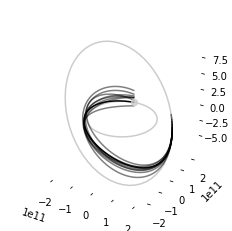

In [28]:
# plot random walks
for i, t in enumerate(T):
    s0 = t[0]
    z = t[1]
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.5)
plt.show()

# Database homotopy $\beta \times [0, 1], \alpha = 0$

In [62]:
#res = seg.homotopy_db_beta(T, alpha, beta, Tlb, Tub, lb, betag, step=0.1)
res = np.load('spacecraft_db_beta_homotopy_a0.npy')

In [63]:
%matplotlib
# plot database homotopy
for i, r in enumerate(res):
    s0, z, seg.beta = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.1)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.1)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Using matplotlib backend: TkAgg


In [77]:
gT = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
gT[0]

array([array([-2.52166457e+10,  1.44924279e+11, -3.82769158e+04, -2.98330342e+04,
       -5.21794677e+03,  1.37814665e-03,  1.00000000e+03]),
       array([ 3.66647875e+02,  7.40814267e-01,  1.42396048e+01, -4.34249440e+01,
       -8.59948806e+00,  4.83638947e+01,  3.90951580e-02, -9.08757515e+00,
        6.76643474e+00])], dtype=object)

In [ ]:
s0zl = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
alpha = 0
alphag = 1
seg.beta == 0.999
T = seg.homotopy_db(s0zl, alpha, Tlb, Tub, lb, alphag, step=0.1)

z=[367.67511395   0.85450776  13.42208432 -44.53245683  -5.63701593
  48.77420388   1.47032107  -6.29833064   7.16404647]
a=0.0
z=[370.3295601    0.97983335  13.15766809 -44.61283557  -6.10363794
  49.26736177   2.02327723  -5.80530079   7.69523848]
a=0.0
z=[ 3.64486642e+02  6.88677266e-01  1.39095829e+01 -4.21482309e+01
 -8.21554097e+00  4.70317202e+01 -7.56545470e-02 -8.68237802e+00
  6.53520755e+00]
a=0.0
z=[ 3.66647875e+02  7.40814267e-01  1.42396048e+01 -4.34249440e+01
 -8.59948806e+00  4.83638947e+01  3.90951580e-02 -9.08757515e+00
  6.76643474e+00]
a=0.0
z=[367.15274819   0.8449775   13.94671784 -44.3323304   -5.23669508
  48.96460658   0.75879665  -5.75279765   6.78874192]
a=0.1
z=[365.95309682   0.72903381  14.86372567 -43.44868648  -7.86537072
  48.7642463   -0.71309816  -8.16003447   6.42333602]
a=0.1
z=[365.73261659   0.70902987   9.83572252 -32.68084402  -7.16845024
  35.90982193   1.05870545  -7.75621795   5.44965407]
a=0.1
z=[ 3.66547590e+02  8.34024805e-01  1.46301467e+